.Implementación de los algoritmos de segmentación.

-K-means Clustering Algorithm. - Randomly initialized (N)
-Mean-Shift Clustering Algorithm. - Centroid Density
-DBSCAN – Density-Based Spatial Clustering of Applications with Noise - Density excluding noise 
-Expectation-Maximization (EM) Clustering using Gaussian Mixture Models (GMM) - data distribution but randomly initialized. (N).

Los datos de "df_seg" se consiguieron como se muestra hasta abajo de store_survival_analysis_Matt.ipynb , haciendo merge entre los datos de ventas de un R, scores de DFM y dataset con type y online days without orders.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter

from lifelines import CoxPHFitter

df_seg = pd.read_csv('r_segmentation_data_bueno.csv', encoding='latin-1')

# K means

In [124]:
#from sklearn import preprocessing
#from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity

1. Drop non numeric values y Elegir número (k) de clusters

In [125]:
df_seg 

,shop_id,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,...,online_days,online_days_without_orders,is_churned_x,seg_shop_id,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency
0,5764607523513172021,317,516,123,16,0.000000,0.000000,80902.0,1186.47,2768.43,...,312.0,18.0,0.0,5.764608e+18,4,78.797468,4.0,25579200.0,3.0,1.0
1,5764607523605446711,323,523,119,26,0.000000,0.000000,117026.0,1894.68,5064.92,...,306.0,12.0,0.0,5.764608e+18,3,71.651090,4.0,22171365.0,3.0,2.0
2,5764607523630612840,212,0,0,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5764607523789996093,352,1615,234,13,0.000000,0.000000,198181.0,2245.75,0.00,...,311.0,3.0,1.0,5.764608e+18,5,95.709571,4.0,9085932.0,1.0,49.0
4,5764607523848716918,71,0,1,1,1736.000000,3224.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42352,5764607791097184336,563,1887,270,84,289.750000,745.250000,703344.0,110364.61,206789.94,...,480.0,7.0,0.0,5.764608e+18,4,88.235294,5.0,162163785.0,3.0,2.0
42353,5764607793362108551,306,80,14,11,0.000000,0.000000,16602.0,2143.34,2143.34,...,165.0,7.0,1.0,5.764608e+18,3,63.713080,1.0,2412.0,1.0,69.0
42354,5764607793898979401,300,275,38,13,0.000000,6859.523810,64815.0,0.00,11690.50,...,196.0,9.0,1.0,5.764608e+18,4,78.000000,4.0,6672955.0,3.0,0.0
42355,5764607794733645912,91,120,9,2,42.736842,2604.105263,21737.0,1438.95,3619.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
indices = ['shop_id', 'seg_shop_id']
#se quitan los indices seleccionados
df_seg = df_seg.drop(indices, axis = 1)

In [127]:
#no se pueden escalar los datos con datos de string
df_seg1 = df_seg[pd.to_numeric(df_seg['frequency_segment'], errors='coerce').notnull()]

In [128]:
#df_seg1 = df_seg1.reset_index()

In [129]:
# Escalamos los datos, porque hay cantidades muy dispersas entre sí y no sería optimo dejarlas así
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_seg1)

In [130]:
df_seg1

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,type,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency
0,317,516,123,16,0.000000,0.00000,80902.0,1186.47,2768.43,1.0,...,2,312.0,18.0,0.0,4,78.797468,4.0,25579200.0,3.0,1.0
1,323,523,119,26,0.000000,0.00000,117026.0,1894.68,5064.92,0.0,...,2,306.0,12.0,0.0,3,71.651090,4.0,22171365.0,3.0,2.0
3,352,1615,234,13,0.000000,0.00000,198181.0,2245.75,0.00,0.0,...,1,311.0,3.0,1.0,5,95.709571,4.0,9085932.0,1.0,49.0
5,309,2064,326,34,932.886905,0.00000,485083.0,5982.00,0.00,0.0,...,1,284.0,4.0,0.0,4,87.378641,5.0,869668750.0,3.0,0.0
6,291,237,38,10,0.000000,0.00000,69557.0,15.00,692.00,10.0,...,2,275.0,7.0,0.0,2,54.639175,4.0,10713304.0,3.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42350,534,1435,144,19,0.000000,0.00000,260320.0,0.00,0.00,0.0,...,2,451.0,3.0,0.0,4,88.202247,5.0,59563620.0,3.0,0.0
42352,563,1887,270,84,289.750000,745.25000,703344.0,110364.61,206789.94,0.0,...,2,480.0,7.0,0.0,4,88.235294,5.0,162163785.0,3.0,2.0
42353,306,80,14,11,0.000000,0.00000,16602.0,2143.34,2143.34,5.0,...,2,165.0,7.0,1.0,3,63.713080,1.0,2412.0,1.0,69.0
42354,300,275,38,13,0.000000,6859.52381,64815.0,0.00,11690.50,12.0,...,2,196.0,9.0,1.0,4,78.000000,4.0,6672955.0,3.0,0.0


In [131]:
#se convierte en un array de numpy
df_scaled

array([[-0.03062182, -0.24789673, -0.10886905, ..., -0.14435367,
         0.71275882, -0.37435527],
       [ 0.00347389, -0.2453431 , -0.12150678, ..., -0.14566587,
         0.71275882, -0.33728439],
       [ 0.16826981,  0.15302258,  0.24182807, ..., -0.15070449,
        -1.86569371,  1.40504719],
       ...,
       [-0.09313061, -0.40695116, -0.4532473 , ..., -0.15420214,
        -1.86569371,  2.14646488],
       [-0.12722632, -0.33581443, -0.3774209 , ..., -0.15163361,
         0.71275882, -0.41142615],
       [-0.35453104, -0.39162941, -0.33002939, ..., -0.1541349 ,
        -0.57646744,  0.10756623]])

In [132]:
#Input contains NaN, infinity or a value too large for dtype('float64').
#Si no haces esto saldra el error de arriba, aqui cambias los NaN por un 0 y los numeros infitnitos los haces finitos
df_scaled = np.nan_to_num(df_scaled) 



In [133]:
#para guardar diametros de cada k mean probado con diferentes k
# #para guardar diametros de cada k mean probado con diferentes k
# scores = []

# # para probar con k's de 1 a 15
# range_values = range(1, 15)

# for i in range_values:
#   #creas el objeto k mean con data set escalda
#   kmeans = KMeans(n_clusters = i)
#     #recibe un array
#   kmeans.fit(df_scaled)
#   #guardas en score, la inertia de cada k mean, que es el diametro de un centroide
#   scores.append(kmeans.inertia_) # la inercia (diametro) es la suma de los cuadrados de las distancias de las observaciones al centro del cluster más cercano

# #graficar en x=range values y en y=scores, bx= blue con cruces
# plt.plot(range_values, scores, 'bx-')
# plt.title('Encontrar el número correcto de clusters')
# plt.xlabel('Nº Clusters')
# plt.ylabel('WCSS') 
# plt.show()

# # Detalles de Kmeans en Sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# # Tengamos en cuenta que la curva cambiará cada vez que ejecutemos la celda

Resultados
Corrida 1: hay un cambio significante en k= 7
Corrida 2: hay un cambio significante en k= 7
Se elegirá un k=7

In [134]:
# Agrupar los datos usando k-means

#ya que sabes el K apropiado con metodo del codo, se lo indicas
kmeans = KMeans(4)
#seleccionas el data frame para hacer los clusters
kmeans.fit(df_scaled)
#creo que obtienes a que frupo pertenece cada etiqueta
labels = kmeans.labels_


In [135]:
#7 clusters con 26 columnas cada una (como se observo al reescalarlo pero checar antes de reescalarlo)
kmeans.cluster_centers_.shape

(4, 26)

In [136]:
#  un vistazo a los centros de los clústeres -- df_seg1 es el df que se ocupo para escalar los datos
cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = [df_seg1.columns])
cluster_centers 

#obtienes coordenadas de cada variable graficada pero obvio no se entiende porque además están reescaldas, debes desescalrlas

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,type,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency
0,0.946327,2.353424,2.425266,1.547934,0.526926,0.586864,2.306038,1.642320,1.705214,-0.271052,...,-0.518033,1.000966,-0.530832,-0.507300,1.260220,1.203087,1.251085,1.085097,0.687603,-0.403420
1,-0.566625,-0.400515,-0.435701,-0.304111,-0.165753,-0.174539,-0.382910,-0.227060,-0.243902,0.228578,...,0.256664,-0.578658,-0.177381,0.574936,-0.716649,-0.736994,-0.891149,-0.153811,-0.741310,0.498199
2,1.014533,8.688664,7.689741,3.537459,0.770897,0.656251,9.223431,7.520718,7.372794,-0.323421,...,-0.643291,1.047460,-0.719457,-0.499527,1.307330,1.278547,1.265469,11.752918,0.694341,-0.404012
3,0.348125,-0.044340,-0.015679,0.023496,0.064588,0.065033,-0.057444,-0.087661,-0.080473,-0.155896,...,-0.144261,0.350821,0.227768,-0.417966,0.431659,0.456838,0.581851,-0.110812,0.534036,-0.367238


# Descripcion por cluster

In [137]:
# Para entender lo que significan estos números, realicemos una transformación inversa, o sea desescalas los datos
cluster_centers = scaler.inverse_transform(cluster_centers)
#guardas el data desescalado
cluster_centers = pd.DataFrame(data = cluster_centers, columns = [df_seg1.columns])

#estos son los 7 clusters y sus características
cluster_centers

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,type,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency
0,488.918847,7646.741020,925.085144,124.024390,1219.849186,4451.602372,1.536896e+06,102583.036284,248617.523268,2.005322,...,1.079379,388.062528,2.262528,0.060754,4.933038,97.163855,4.980488,3.218500e+09,2.980488,0.215965
1,222.676773,97.642292,19.553628,5.876231,322.197321,1574.142513,1.765876e+04,696.277976,1945.321778,15.208617,...,1.702858,139.502636,4.855835,0.552449,2.123075,46.846785,2.074580,1.018210e+06,1.872138,24.537464
2,500.921429,25012.900000,2591.357143,250.942857,1536.013673,4713.825390,5.445176e+06,422973.349714,965883.454857,0.621429,...,0.978571,395.378571,0.878571,0.064286,5.000000,99.120962,5.000000,3.092317e+10,2.985714,0.200000
3,383.650121,1073.990841,152.495657,26.775335,620.698258,2479.520848,2.015451e+05,8293.895705,22628.213197,5.048455,...,1.380193,285.759735,7.828458,0.101341,3.755303,77.809476,4.072682,1.126883e+08,2.861372,1.191987


Cluster 0
-churn:  ALTA probabilidad
-151 dias en linea, 5 día sin ordenes
-frecuency-seg: 2.7
-monetary-seg: 1.7
-recency-seg: 4.9
pocos dias y muchos sin ordenes

Cluster 1
-churn: BAJA probabilidad
-354 dias en linea, 9 día sin ordenes
-frecuency-seg: 4
-monetary-seg: 4.3
-recency-seg: 2.5

Cluster 2
-churn: MUY BAJA probabilidad
-467 dias en linea, 3 día sin ordenes
-frecuency-seg: 4.9
-monetary-seg: 4.9
-recency-seg: 2

Cluster 3
-churn: NULA probabilidad
-493 dias en linea, 1 día sin ordenes
-frecuency-seg: 5
-monetary-seg: 5
-recency-seg: 2

Cluster 4
-churn: MEDIANA probabilidad (EN RIESGO si pasan más días??)
-142 dias en linea, 5 día sin ordenes
-frecuency-seg: 2
-monetary-seg: 2.7
-recency-seg: 3.1



0:3500
1: 7500
2: 700
3: 36
4:10000

 


In [100]:
#cuantas filas existen -> fila = observacion

labels.shape # Etiquetas del clúster asociado a cada observación

(33732,)

In [101]:
#guardas como target Y (target a predecir)
y_kmeans = kmeans.fit_predict(df_scaled)
 #cada label de cluster correspndiente a cada fila del df
y_kmeans

array([2, 2, 0, ..., 0, 2, 2])

In [102]:
#debe de ser el mismo numero de labels y de filas en df_scaled
y_kmeans.shape

(33732,)

Deberemos de concatenar las labels al df_seg1 pero recuerda que se le quitaron valores para poder el calculo asi que debe de hacerse eso para que corresponda la etiqueta al R.


In [103]:
#si no reinicias los index tendrás columnas extras -> SOLO PUEDES CORRERLO UNA VEZ
df_seg1 = df_seg1.reset_index()

In [104]:


#se guarda en un dataframe las etiquetas para concatenarlo al dataframe original
cluster = pd.DataFrame({'cluster':labels})

#ahora tenemos un dataset
df_cluster_kmeans = pd.concat([df_seg1, cluster], axis = 1)
f = ['index'
     #,'level_0'
    ]
df_cluster_kmeans = df_cluster_kmeans.drop(f, axis = 1)
df_cluster_kmeans

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
0,317,516,123,16,0.000000,0.00000,80902.0,1186.47,2768.43,1.0,...,312.0,18.0,0.0,4,78.797468,4.0,25579200.0,3.0,1.0,2
1,323,523,119,26,0.000000,0.00000,117026.0,1894.68,5064.92,0.0,...,306.0,12.0,0.0,3,71.651090,4.0,22171365.0,3.0,2.0,2
2,352,1615,234,13,0.000000,0.00000,198181.0,2245.75,0.00,0.0,...,311.0,3.0,1.0,5,95.709571,4.0,9085932.0,1.0,49.0,0
3,309,2064,326,34,932.886905,0.00000,485083.0,5982.00,0.00,0.0,...,284.0,4.0,0.0,4,87.378641,5.0,869668750.0,3.0,0.0,2
4,291,237,38,10,0.000000,0.00000,69557.0,15.00,692.00,10.0,...,275.0,7.0,0.0,2,54.639175,4.0,10713304.0,3.0,0.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33727,534,1435,144,19,0.000000,0.00000,260320.0,0.00,0.00,0.0,...,451.0,3.0,0.0,4,88.202247,5.0,59563620.0,3.0,0.0,2
33728,563,1887,270,84,289.750000,745.25000,703344.0,110364.61,206789.94,0.0,...,480.0,7.0,0.0,4,88.235294,5.0,162163785.0,3.0,2.0,2
33729,306,80,14,11,0.000000,0.00000,16602.0,2143.34,2143.34,5.0,...,165.0,7.0,1.0,3,63.713080,1.0,2412.0,1.0,69.0,0
33730,300,275,38,13,0.000000,6859.52381,64815.0,0.00,11690.50,12.0,...,196.0,9.0,1.0,4,78.000000,4.0,6672955.0,3.0,0.0,2


In [105]:
df_cluster_kmeans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33732 entries, 0 to 33731
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alive_time                    33732 non-null  int64  
 1   completed_orders              33732 non-null  int64  
 2   cancelled_orders              33732 non-null  int64  
 3   b_cancelled_orders            33732 non-null  int64  
 4   avg_b_burn                    31276 non-null  float64
 5   r_burn                        31276 non-null  float64
 6   sum_order_price               33732 non-null  float64
 7   sum_p_promo_subsidy           33732 non-null  float64
 8   sum_r_promo_subsidy           33732 non-null  float64
 9   first_online_first_order_gap  33732 non-null  float64
 10  last_online_last_order_gap    33732 non-null  float64
 11  last_month_promotions         12353 non-null  float64
 12  avg_rnb_burn                  31276 non-null  float64
 13  a

In [106]:
import matplotlib.pyplot as plt

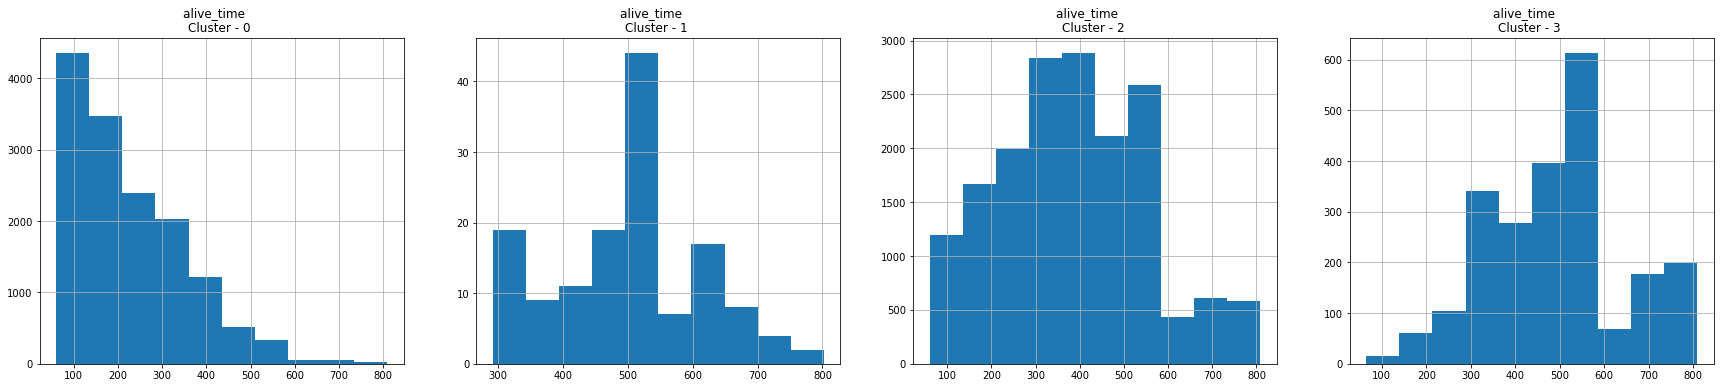

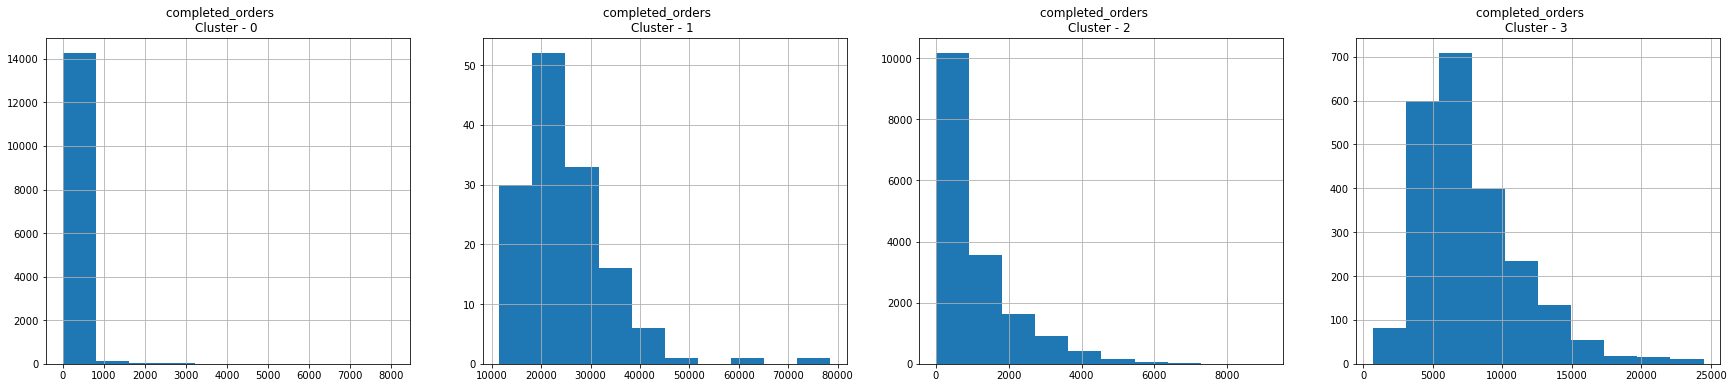

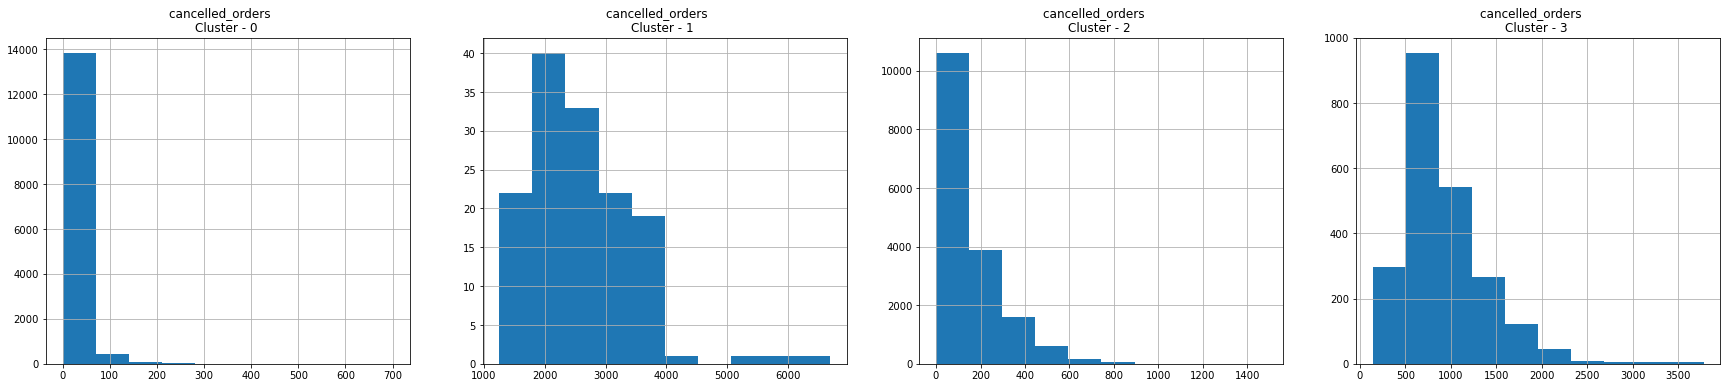

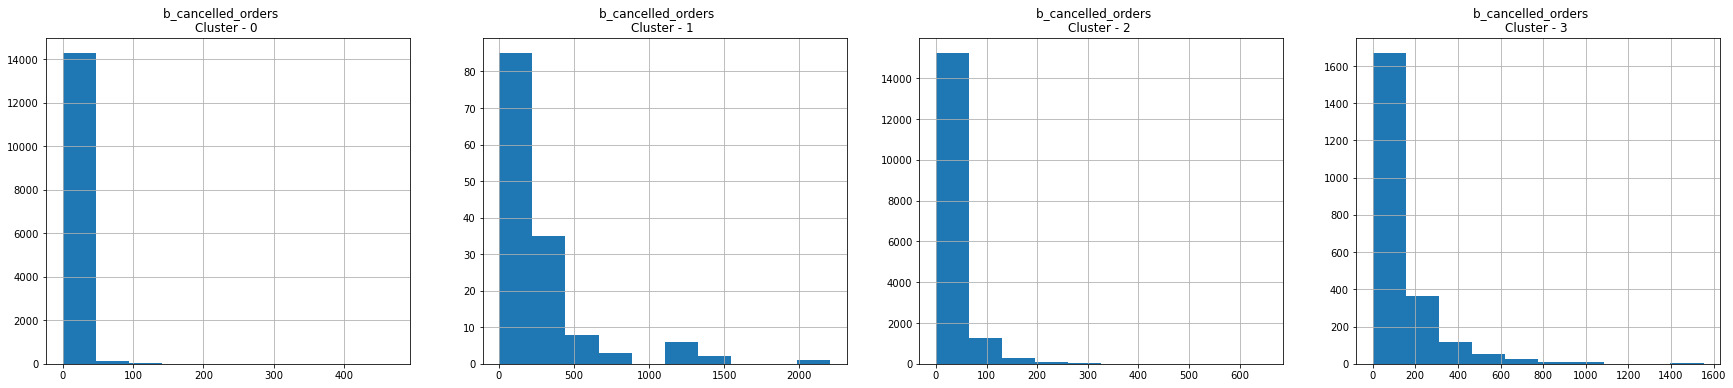

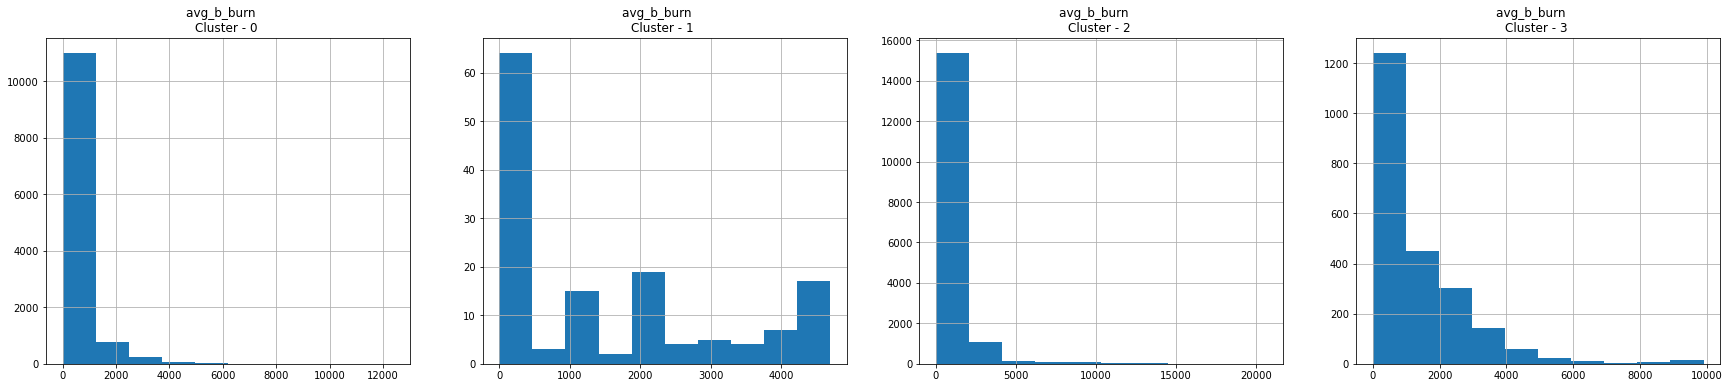

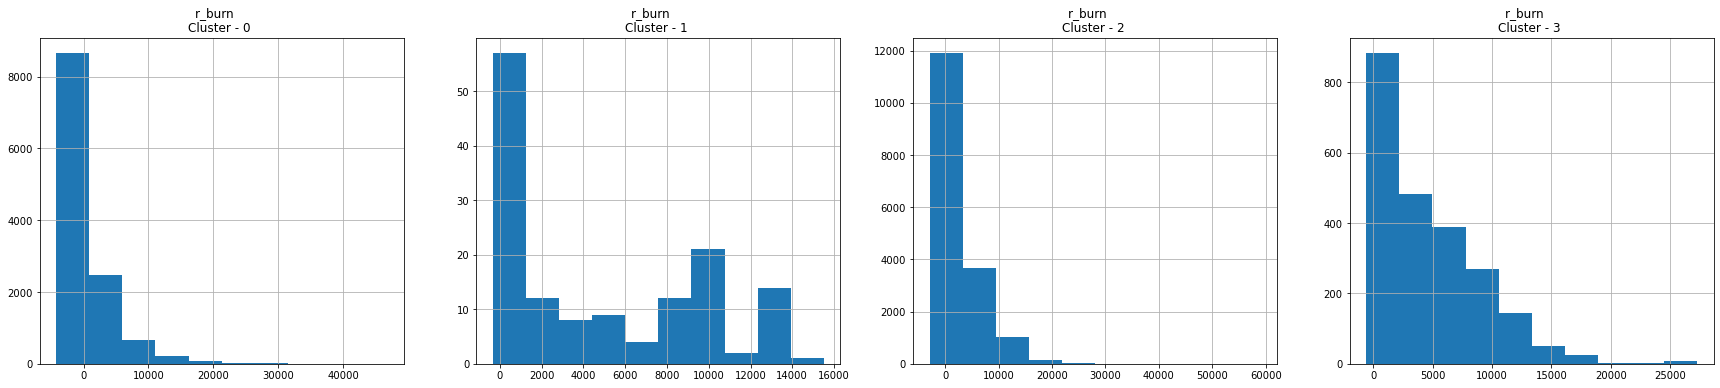

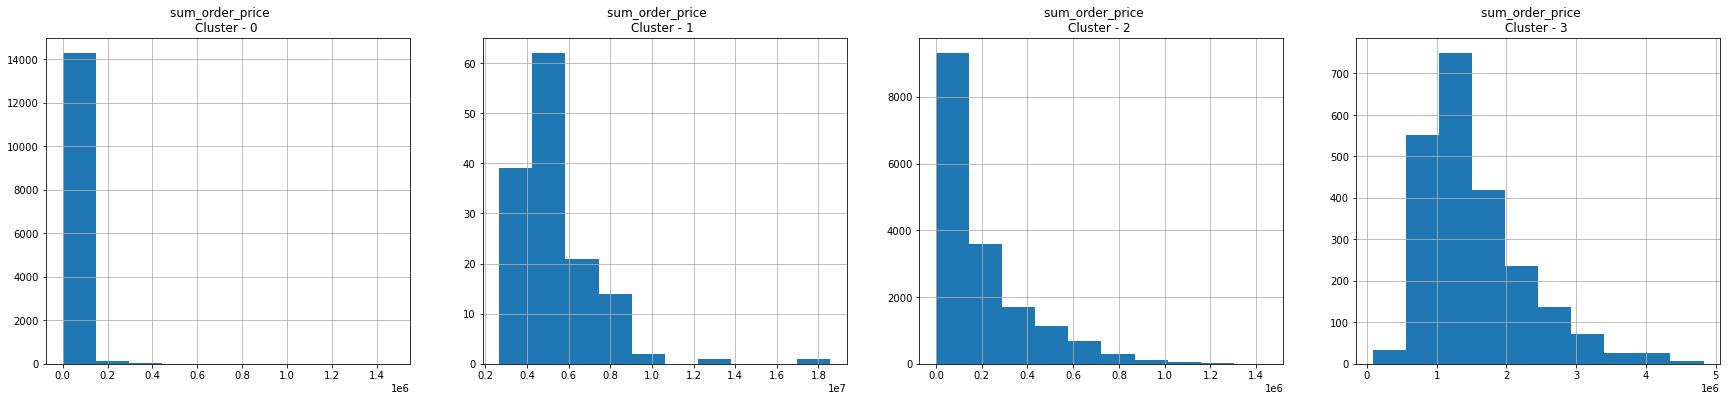

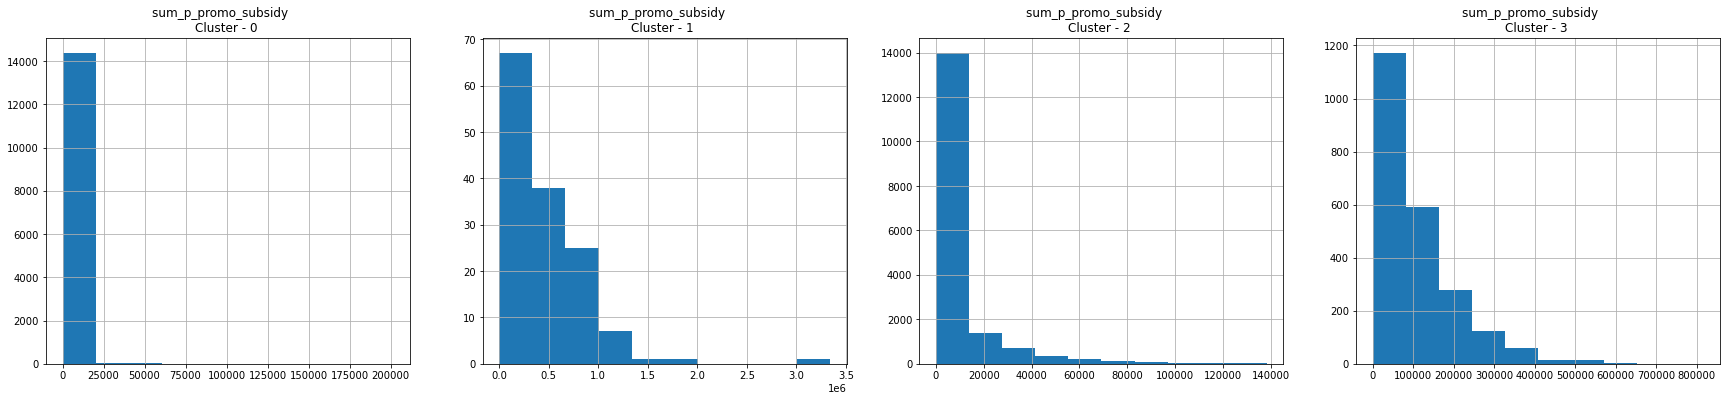

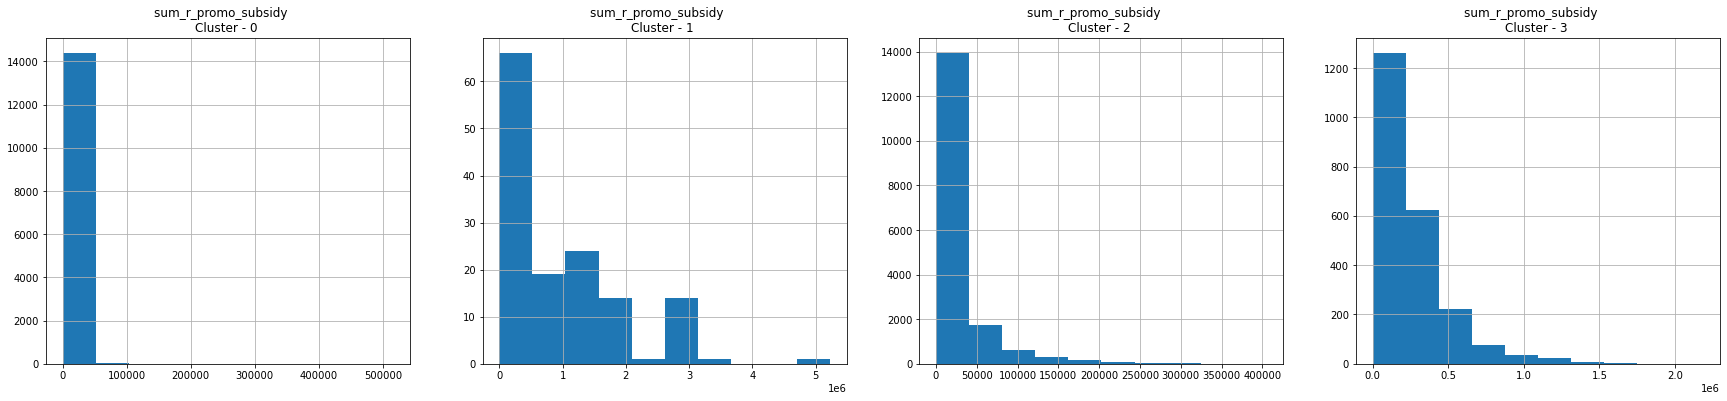

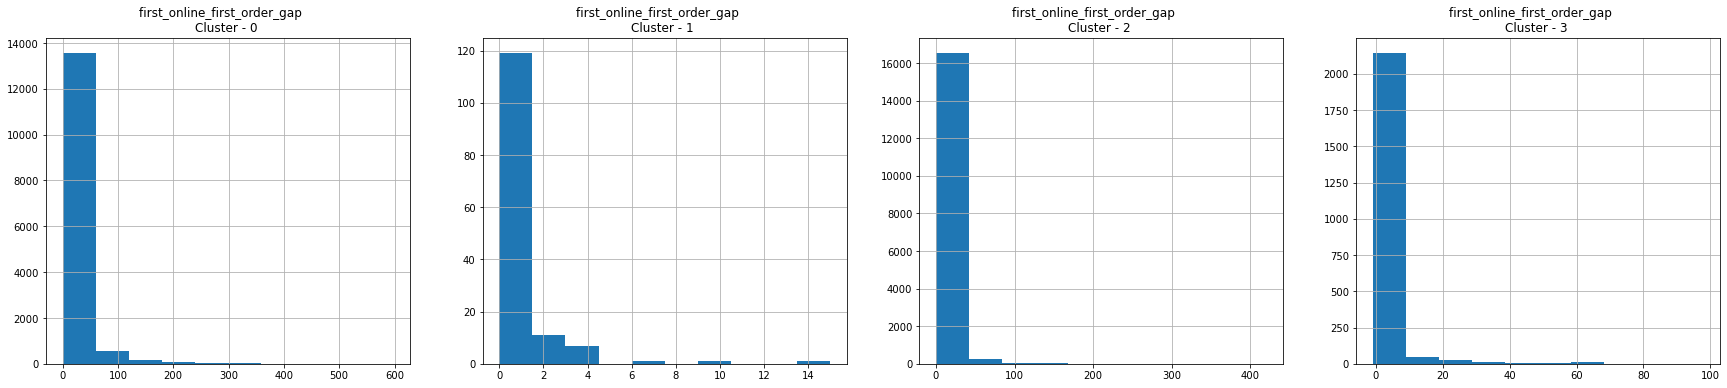

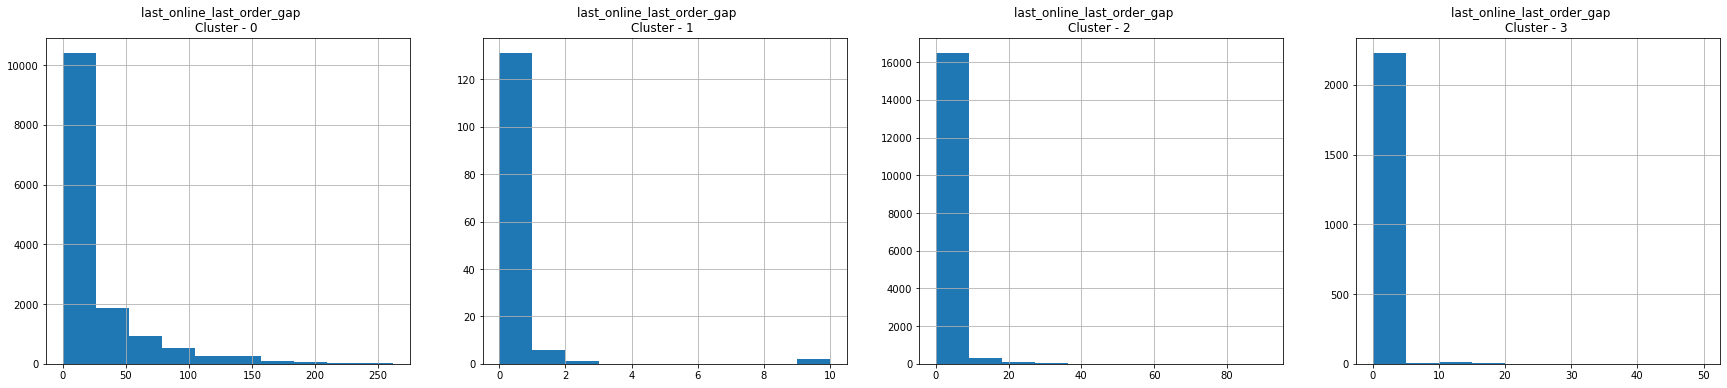

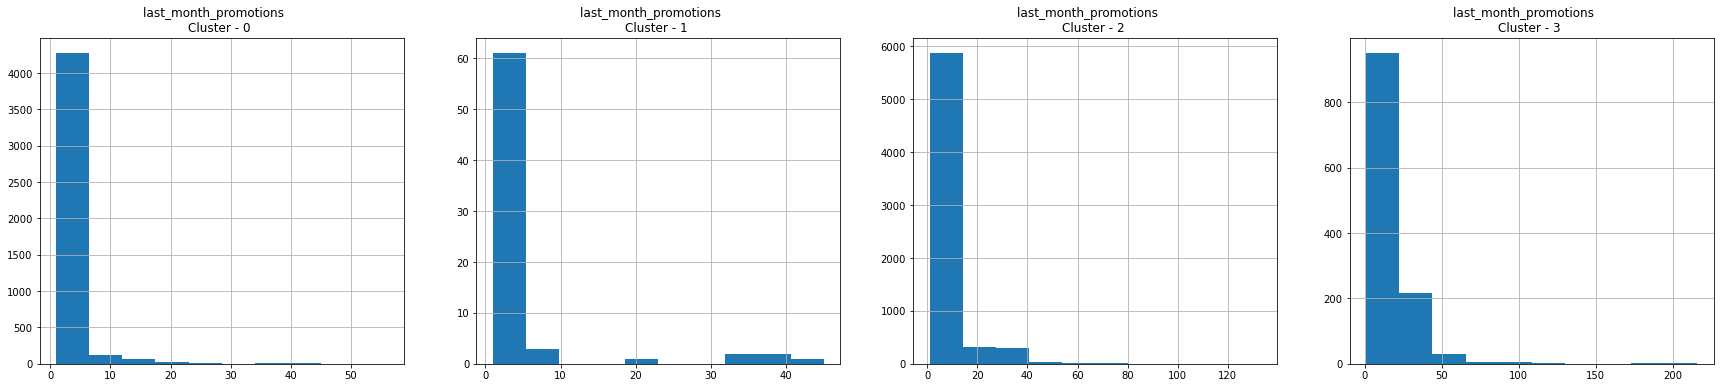

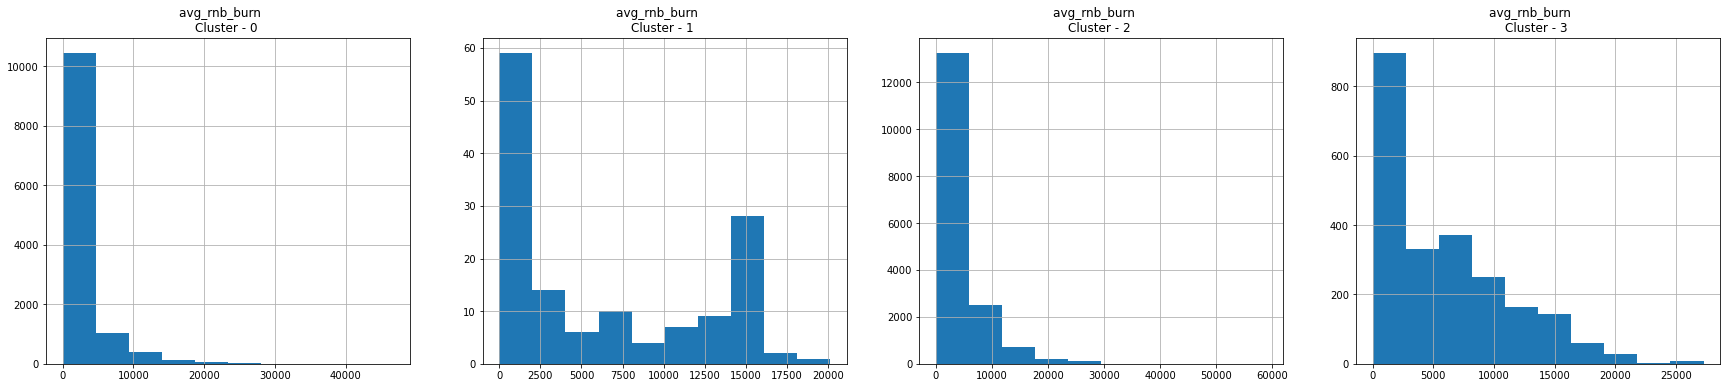

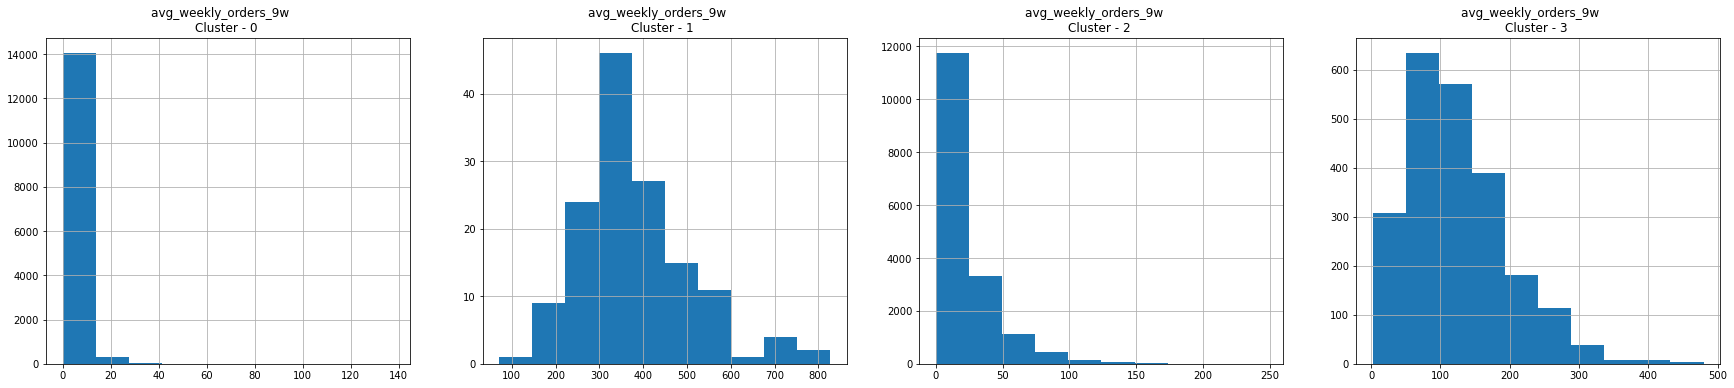

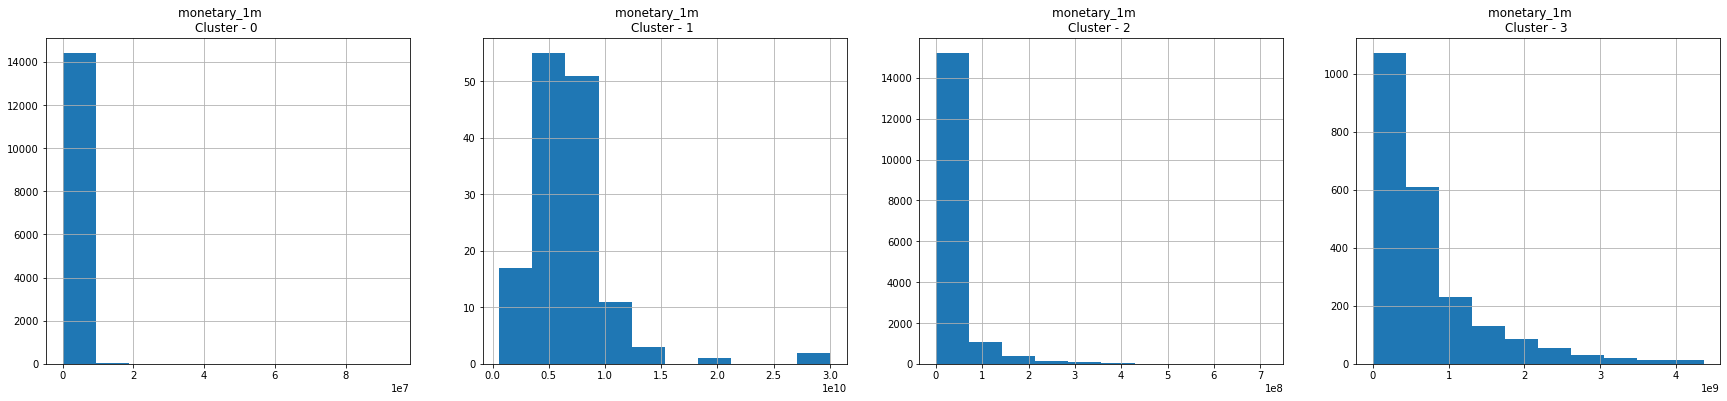

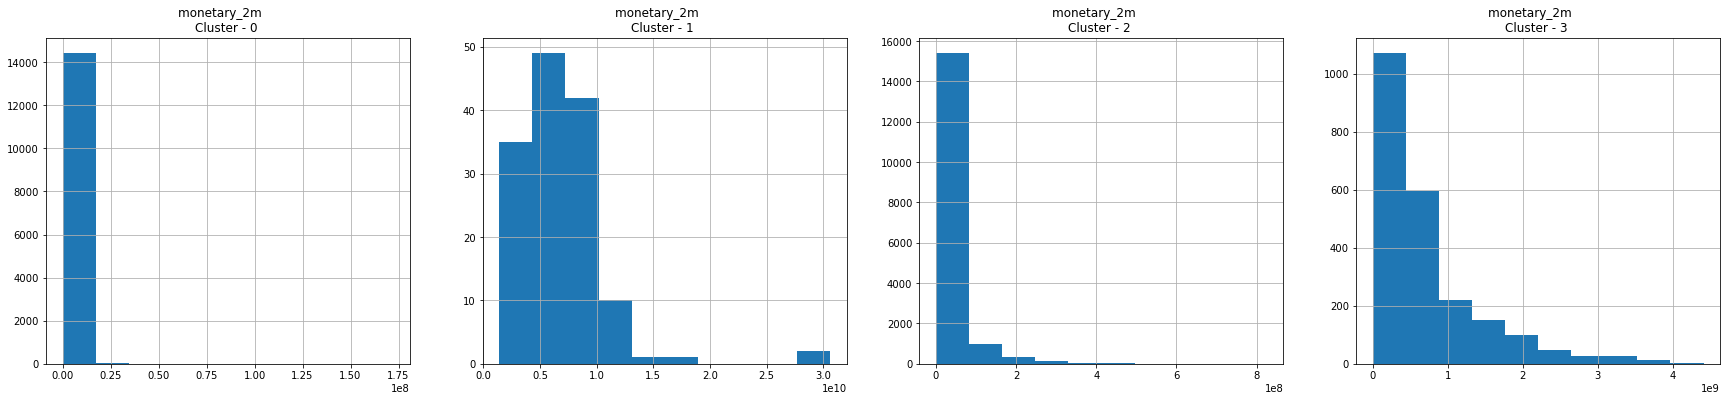

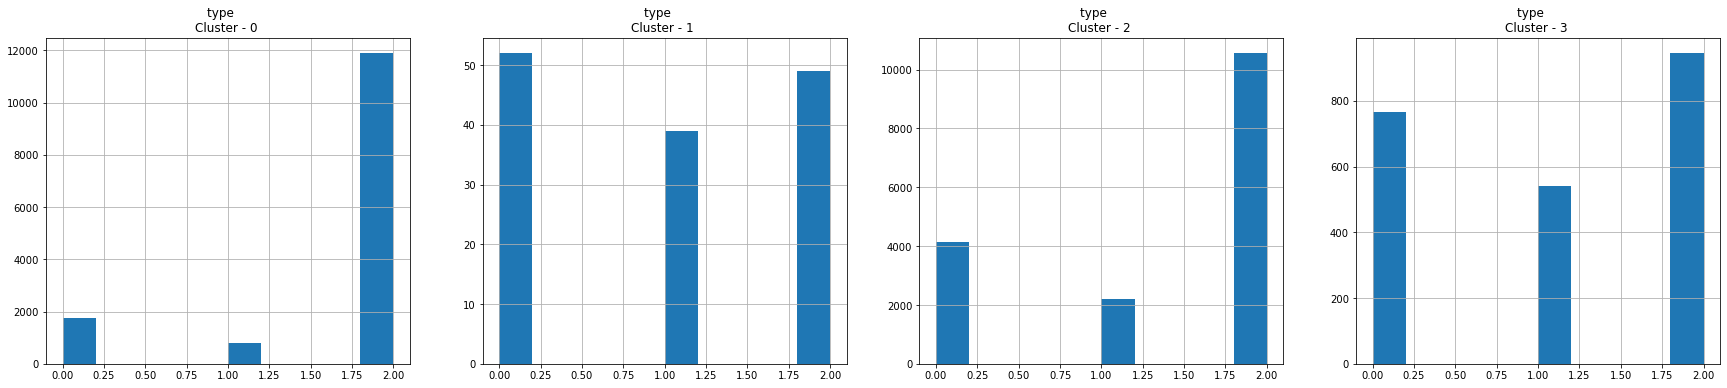

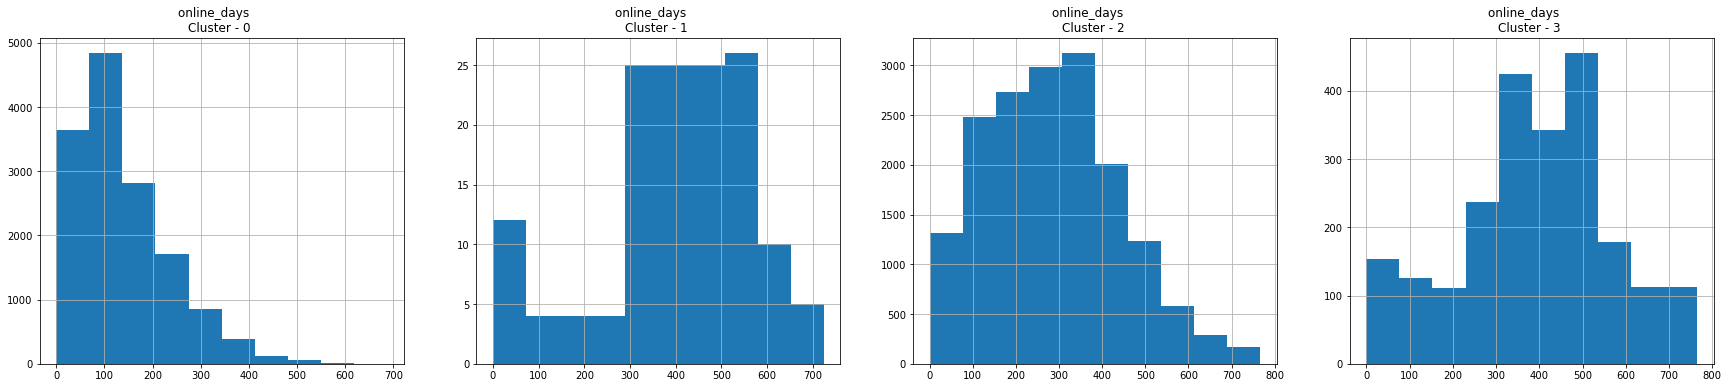

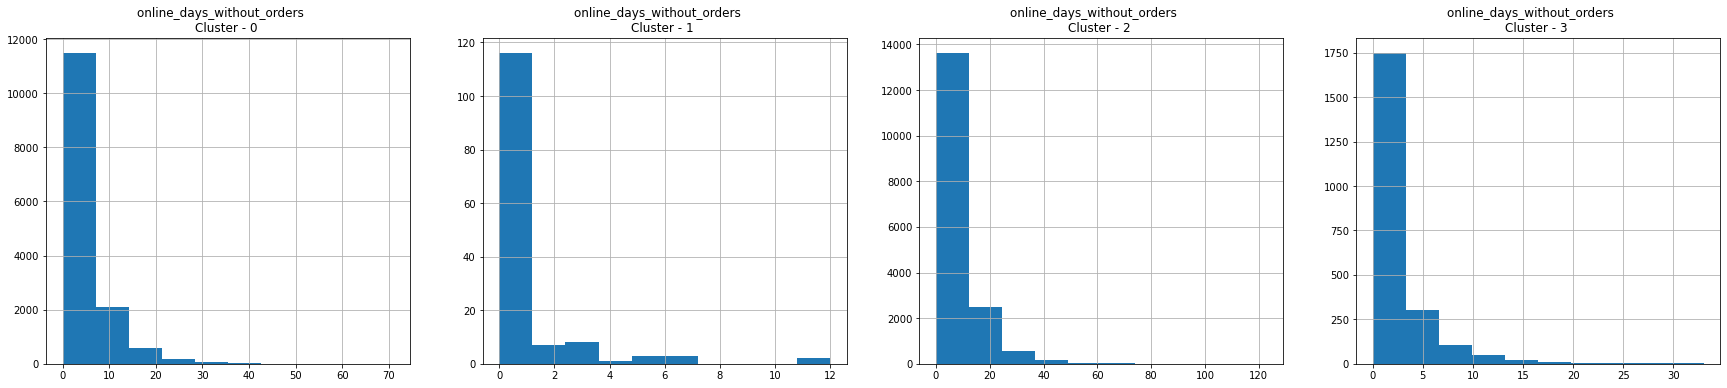

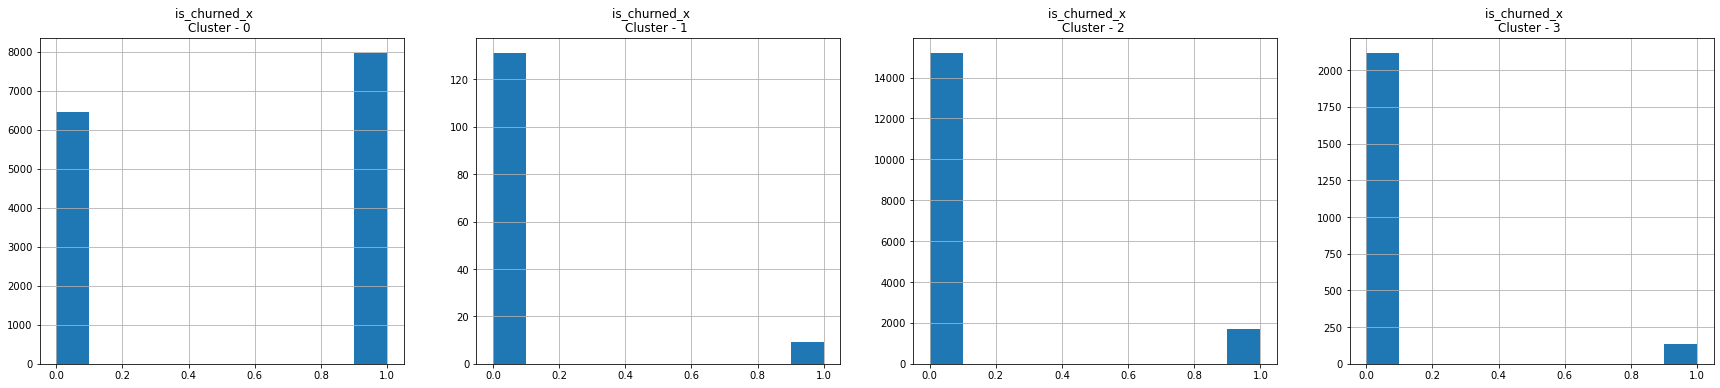

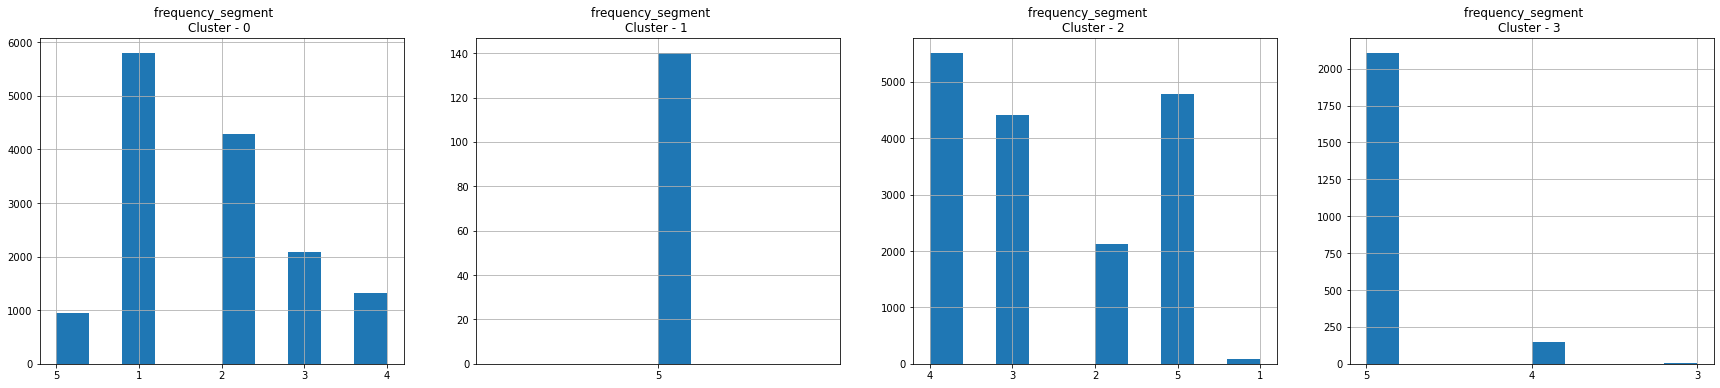

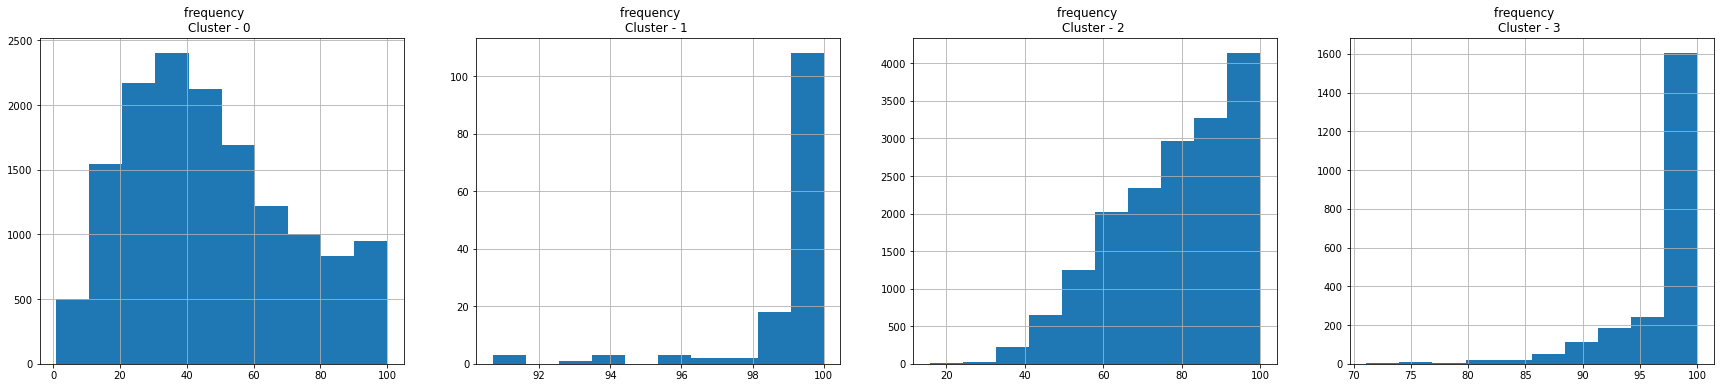

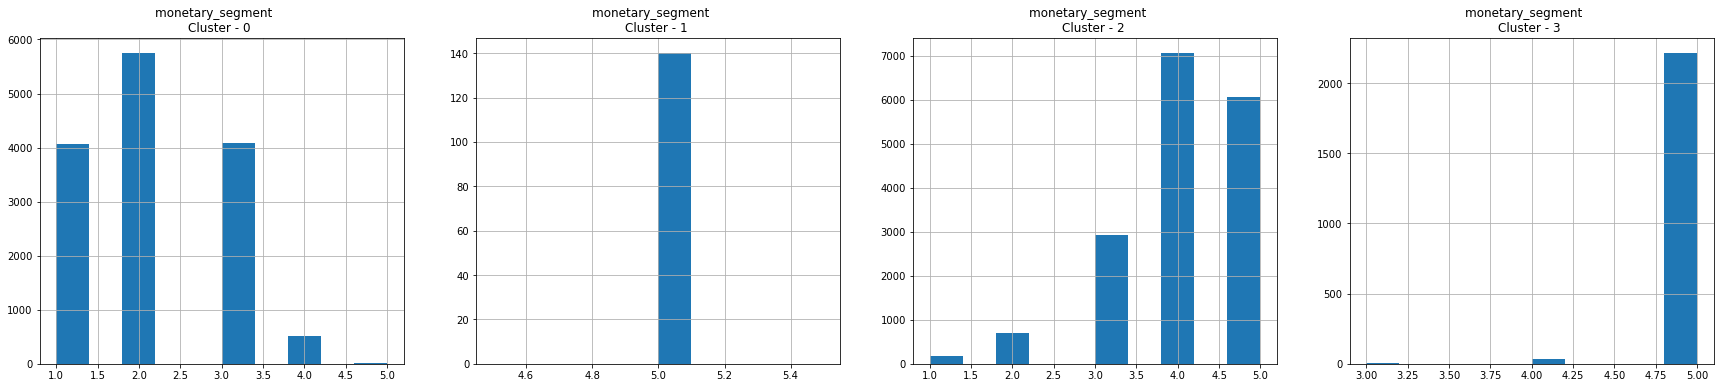

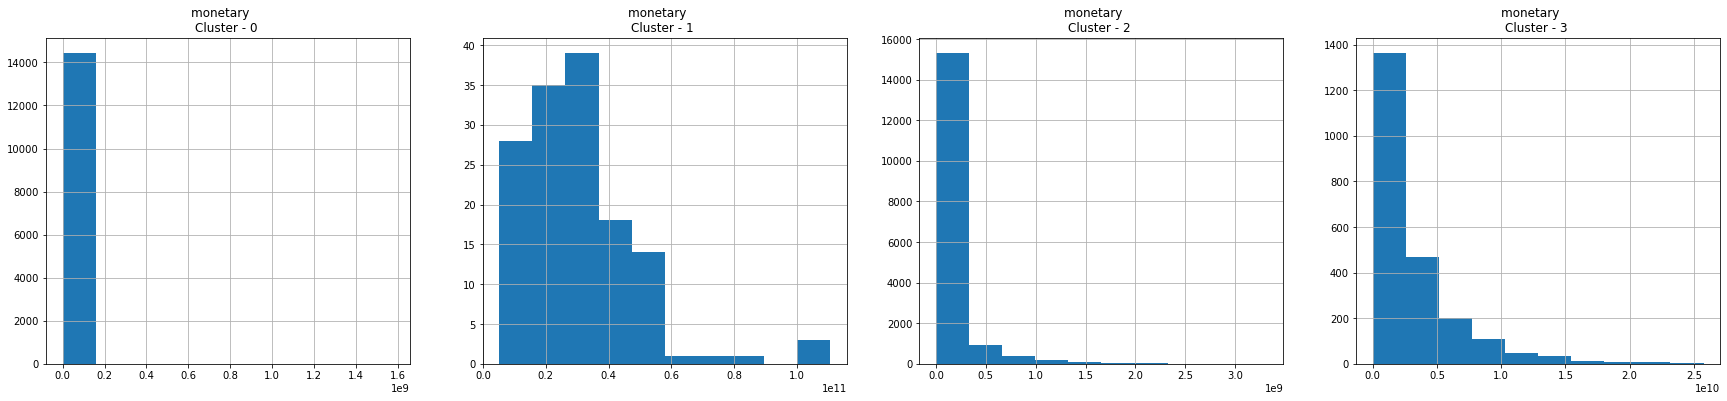

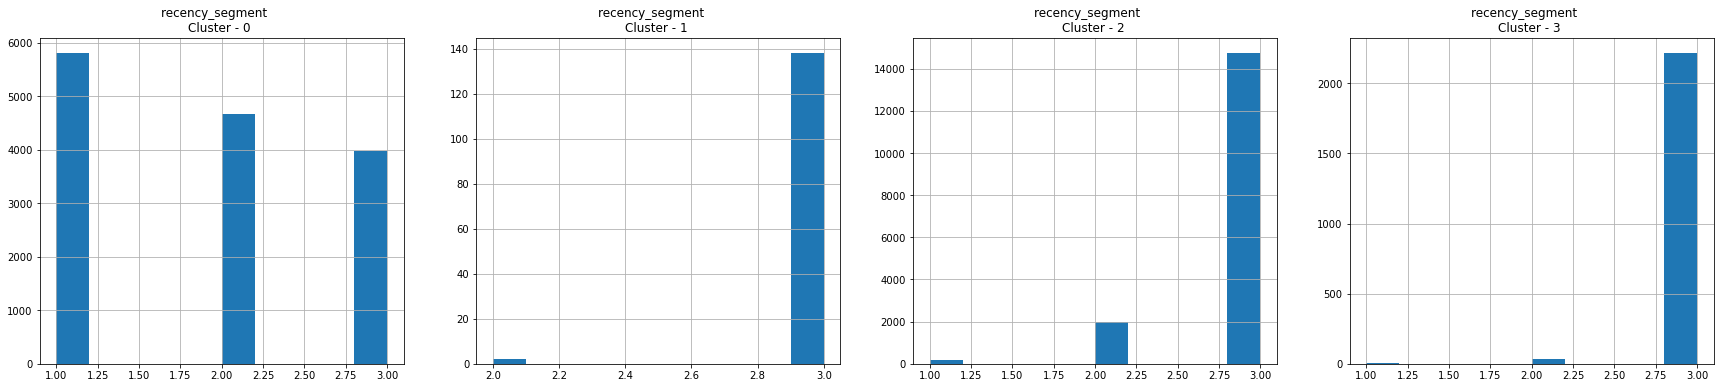

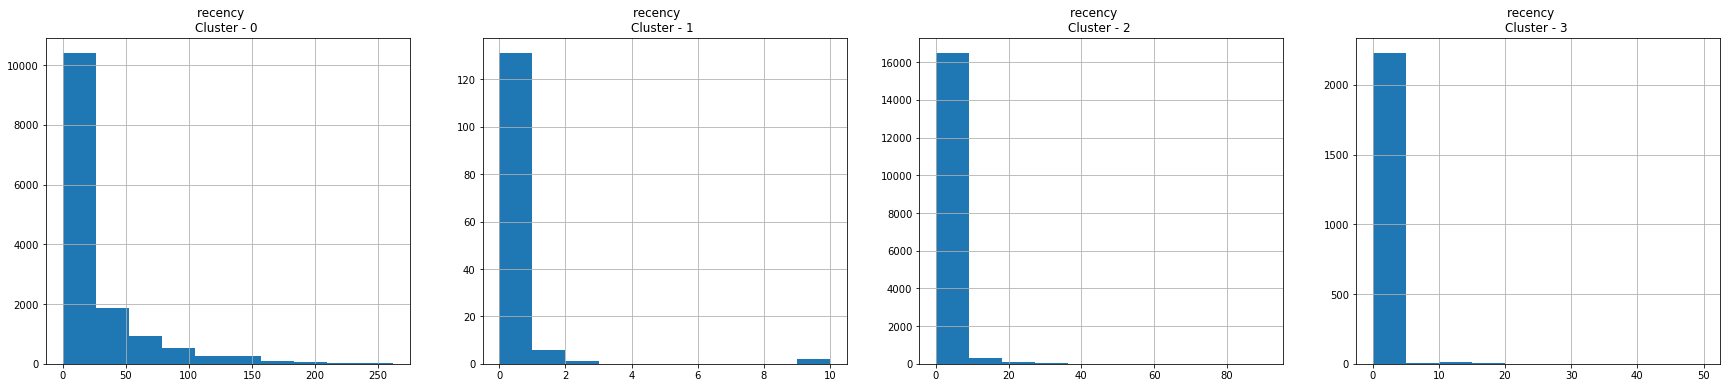

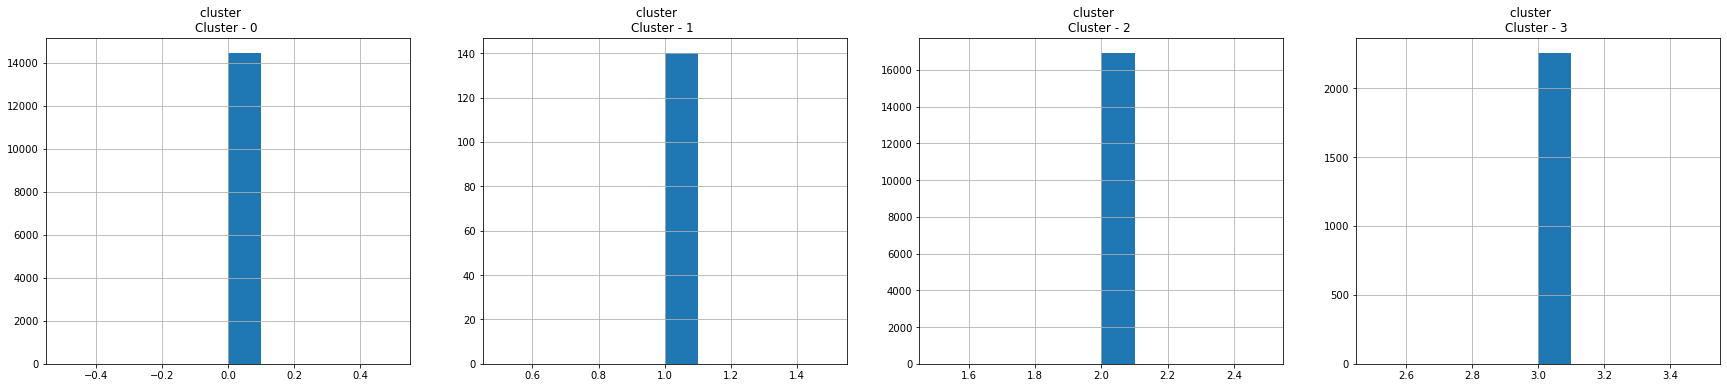

In [107]:
#graficas las filas cuantitavias de cada cluster
# #solo graficaras para las primeras 8 columnas
# for i in df_cluster_kmeans.columns[:27]:
#   plt.figure(figsize = (30, 6))
#   for j in range(4):
#     plt.subplot(1, 4, j+1)
#     cluster = df_cluster_kmeans[df_cluster_kmeans['cluster'] == j]
#     cluster[i].hist()
#     plt.title('{}    \nCluster - {} '.format(i,j))
  
#   plt.show()

# #en x está la variable dependiente(ventas, mes, etc) y en y como la cantidad acumulativa 

1. raw data
3. recency
4.
2. lifetable


# ----- Models-----

In [108]:
from lifelines import CoxPHFitter
from lifelines.plotting import plot_lifetimes
from lifelines import KaplanMeierFitter

# Kaplan model for clusters "alive time"

Text(0, 0.5, 'Survival probability %')

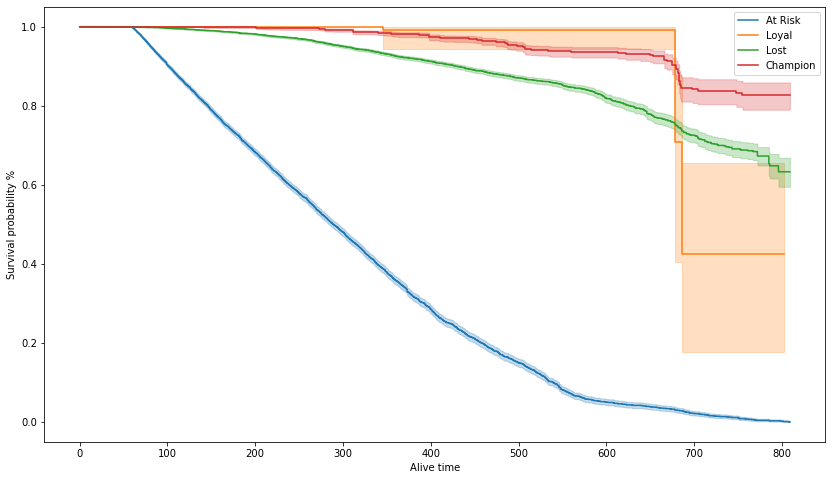

In [109]:
#eje x: T: dias sin ordenes
Tc = df_cluster_kmeans['alive_time']    ## days with 0 orders before last online
#eje y: C: churn: probablididad de que NO haga churn
Cc = df_cluster_kmeans['is_churned_x']     ## R churned X or retained

#clusters
cls = df_cluster_kmeans['cluster']             ## Create the cohorts from the 'cluster' column
c0 = (cls == 0)    
c1 = (cls == 1)    
c2 = (cls == 2)    
c3 = (cls == 3)    
c4 = (cls == 4)

kmf = KaplanMeierFitter() 
#fit el modelo R normal (así mismo para los otros 2)
kmf.fit(Tc[c0], Cc[c0], label='At Risk')    ## fit the cohort 1 data
ax = kmf.plot(figsize=(14,8))

kmf.fit(Tc[c1], Cc[c1], label='Loyal')    ## fit the cohort 2 data
ax1 = kmf.plot(figsize=(14,8), ax=ax)

kmf.fit(Tc[c2], Cc[c2], label='Lost')    ## fit the cohort 2 data
ax2 = kmf.plot(figsize=(14,8), ax=ax1)

kmf.fit(Tc[c3], Cc[c3], label='Champion')    ## fit the cohort 2 data
ax3 = kmf.plot(figsize=(14,8), ax=ax2)

ax3.set_xlabel("Alive time")
ax3.set_ylabel("Survival probability %")
#kmf.fit(Tc[c4], Cc[c4], label='Cluster 4')    ## fit the cohort 2 data
#ax4 = kmf.plot(figsize=(14,8), ax=ax3)

# # Kaplan model for clusters "online days"

Text(0, 0.5, 'Survival probability %')

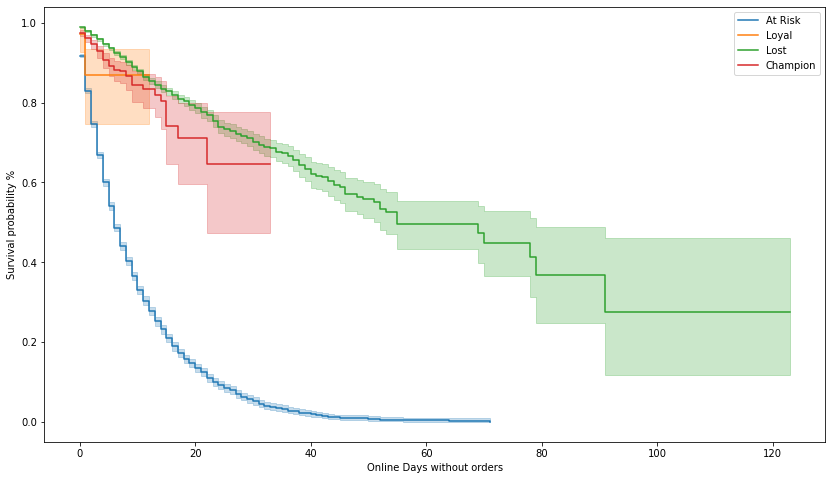

In [110]:
#time alive
Ta = df_cluster_kmeans['online_days_without_orders']   

kmf2 = KaplanMeierFitter() 
#fit el modelo R normal (así mismo para los otros 2)
kmf2.fit(Ta[c0], Cc[c0], label='At Risk')    ## fit the cohort 1 data
ax = kmf2.plot(figsize=(14,8))

kmf2.fit(Ta[c1], Cc[c1], label='Loyal')    ## fit the cohort 2 data
ax1 = kmf2.plot(figsize=(14,8), ax=ax)

kmf2.fit(Ta[c2], Cc[c2], label='Lost')    ## fit the cohort 2 data
ax2 = kmf2.plot(figsize=(14,8), ax=ax1)

kmf2.fit(Ta[c3], Cc[c3], label='Champion')    ## fit the cohort 2 data
ax3 = kmf2.plot(figsize=(14,8), ax=ax2)

ax3.set_xlabel("Online Days without orders")
ax3.set_ylabel("Survival probability %")

#kmf2.fit(Ta[c4], Cc[c4], label='Cluster 4')    ## fit the cohort 2 data
#ax4 = kmf2.plot(figsize=(14,8), ax=ax3)

# Cox Hazard online days without orders

In [111]:
col_list_2 = [
    'alive_time',
    'online_days_without_orders',
    'is_churned_x',
    #'type',
    'frequency_segment',
    'monetary_segment',
    'recency_segment',
    'cluster',
    'cancelled_orders',
    'b_cancelled_orders',
    #'avg_b_burn',
    'last_online_last_order_gap',
    #'cancelled_perc',
    #'b_cancelled_perc',
    #'bad_rated_perc',
    #'last_month_promotions',
    #'b_burn_perc',
    #'avg_rnb_burn',
    #'avg_daily_orders'
    'avg_weekly_orders_9w',
    #'monetary_1m',
    'monetary_2m',
    #'r_burn'
]

df_tree = df_cluster_kmeans[col_list_2]
df_tree = df_tree

#hace falta pasar df_tree a puros numeros para que no de error, ya que en frecuency segment existia
df_tree = df_tree[pd.to_numeric(df_tree['frequency_segment'], errors='coerce').notnull()]

# Using Cox Proportional Hazards model
cph = CoxPHFitter()   ## Instantiate the class to create a cph object



#(datosParaEntrenar 'ColumnaDefactorQueInfluyeD(duracionOTiempo)' 'ColumnaDeEventoApredecir' )
cph.fit(df_tree, 'online_days_without_orders', event_col='is_churned_x')   ## Fit the data to train the model
cph.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 33732 total observations, 23908 right-censored observations>
             duration col = 'online_days_without_orders'
                event col = 'is_churned_x'
      baseline estimation = breslow
   number of observations = 33732
number of events observed = 9824
   partial log-likelihood = -86523.51
         time fit was run = 2021-06-30 21:05:56 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
alive_time                  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
frequency_segment            0.27       1.30       0.01             0.25             0.28                 1.28                 1.33
monetary_segment            -0.49       0.61       0.01            -0.51            -0.46                 0.60                 0.63
recency_segment             -0.30       0.74       0.02            -0.34            -0.26                 0.72                 0.77
cluster                     -0.36       0.70       0.02            -0.40            -0.32                 0.67                 0.73
cancelled_orders             0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
b_cancelled_orders          -0.01       0.99       0.00            -0.01            -0.01                 0.99                 0.99
last_online_last_order_gap   0.00       1.00       0.00             0.00             0.00                 1.00                 1.00
avg_weekly_orders_9w         0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
monetary_2m                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                                z      p   -log2(p)
covariate                                          
alive_time                 -41.65 <0.005        inf
frequency_segment           32.23 <0.005     754.71
monetary_segment           -36.06 <0.005     943.65
recency_segment            -16.63 <0.005     203.85
cluster                    -17.74 <0.005     231.50
cancelled_orders            16.56 <0.005     202.31
b_cancelled_orders         -16.28 <0.005     195.42
last_online_last_order_gap  14.72 <0.005     160.46
avg_weekly_orders_9w         5.47 <0.005      24.44
monetary_2m                 -6.40 <0.005      32.57
---
Concordance = 0.84
Partial AIC = 173067.02
log-likelihood ratio test = 15176.89 on 10 df
-log2(p) of ll-ratio test = inf

In [112]:
df_treeA = df_cluster_kmeans[col_list_2]


#hace falta pasar df_tree a puros numeros para que no de error, ya que en frecuency segment existia
df_treeA = df_treeA[pd.to_numeric(df_treeA['frequency_segment'], errors='coerce').notnull()]

# Using Cox Proportional Hazards model
cph2 = CoxPHFitter()   ## Instantiate the class to create a cph object



#(datosParaEntrenar 'ColumnaDefactorQueInfluyeD(duracionOTiempo)' 'ColumnaDeEventoApredecir' )
cph2.fit(df_treeA, 'alive_time', event_col='is_churned_x')   ## Fit the data to train the model
cph2.print_summary()    ## HAve a look at the significance of the features

<lifelines.CoxPHFitter: fitted with 33732 total observations, 23908 right-censored observations>
             duration col = 'alive_time'
                event col = 'is_churned_x'
      baseline estimation = breslow
   number of observations = 33732
number of events observed = 9824
   partial log-likelihood = -87636.43
         time fit was run = 2021-06-30 21:05:58 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                          
online_days_without_orders  -0.04       0.96       0.00            -0.04            -0.04                 0.96                 0.96
frequency_segment            0.02       1.02       0.01             0.00             0.04                 1.00                 1.04
monetary_segment            -0.36       0.70       0.01            -0.38            -0.33                 0.68                 0.72
recency_segment             -0.16       0.85       0.02            -0.20            -0.13                 0.82                 0.88
cluster                     -0.90       0.41       0.02            -0.94            -0.86                 0.39                 0.42
cancelled_orders            -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
b_cancelled_orders           0.00       1.00       0.00             0.00             0.01                 1.00                 1.01
last_online_last_order_gap  -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00
avg_weekly_orders_9w         0.01       1.01       0.00             0.01             0.02                 1.01                 1.02
monetary_2m                 -0.00       1.00       0.00            -0.00            -0.00                 1.00                 1.00

                                z      p   -log2(p)
covariate                                          
online_days_without_orders -21.14 <0.005     326.95
frequency_segment            2.51   0.01       6.38
monetary_segment           -25.84 <0.005     486.48
recency_segment             -8.81 <0.005      59.49
cluster                    -43.37 <0.005        inf
cancelled_orders           -11.34 <0.005      96.63
b_cancelled_orders          12.47 <0.005     116.08
last_online_last_order_gap  -4.75 <0.005      18.92
avg_weekly_orders_9w        17.52 <0.005     225.87
monetary_2m                 -7.25 <0.005      41.15
---
Concordance = 0.85
Partial AIC = 175292.85
log-likelihood ratio test = 16377.50 on 10 df
-log2(p) of ll-ratio test = inf

# Resumen de clusters

In [113]:
#correct the weird values in frequency
df_cluster_kmeans = df_cluster_kmeans[pd.to_numeric(df_cluster_kmeans['frequency_segment'], errors='coerce').notnull()]
df_cluster_kmeans['recency_segment']

0        3.0
1        3.0
2        1.0
3        3.0
4        3.0
        ... 
33727    3.0
33728    3.0
33729    1.0
33730    3.0
33731    2.0
Name: recency_segment, Length: 33732, dtype: float64

In [114]:
df_cluster_kmeans["frequency_segment"] = pd.to_numeric(df_cluster_kmeans["frequency_segment"], downcast="float")


In [115]:
df_cluster_kmeans.describe()

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
count,33732.000000,33732.000000,33732.000000,33732.000000,31276.000000,31276.000000,3.373200e+04,3.373200e+04,3.373200e+04,33732.000000,...,33732.000000,33732.000000,33732.000000,33732.000000,33732.000000,33732.000000,3.373200e+04,33732.000000,33732.000000,33732.000000
mean,322.388681,1195.534507,157.458407,25.276473,536.998418,2233.751939,2.340006e+05,1.307171e+04,3.281256e+04,9.168179,...,230.556652,6.157299,0.291237,3.141735,65.961127,3.283410,4.004702e+08,2.447142,11.098364,1.206718
std,175.977841,2741.240584,316.517128,63.794307,1295.933634,3779.216339,5.650016e+05,5.450380e+04,1.265578e+05,26.426494,...,157.356200,7.337212,0.454339,1.421473,25.935948,1.356505,2.597070e+09,0.775671,26.975748,1.074023
min,60.000000,2.000000,0.000000,0.000000,0.000000,-4200.000000,7.000000e+01,0.000000e+00,0.000000e+00,-1.000000,...,0.000000,0.000000,0.000000,1.000000,0.892857,1.000000,8.600000e+01,1.000000,0.000000,0.000000
25%,172.000000,56.000000,12.000000,2.000000,0.000000,0.000000,1.063575e+04,0.000000e+00,2.500000e+01,0.000000,...,100.000000,1.000000,0.000000,2.000000,46.101094,2.000000,1.342055e+05,2.000000,0.000000,0.000000
50%,310.000000,260.500000,47.000000,8.000000,0.000000,0.000000,4.809850e+04,3.034500e+02,1.481860e+03,2.000000,...,202.000000,4.000000,0.000000,3.000000,70.050133,3.000000,2.845240e+06,3.000000,1.000000,2.000000
75%,443.000000,1049.000000,157.000000,23.000000,519.556091,3428.000000,1.971004e+05,4.320000e+03,1.451826e+04,7.000000,...,334.000000,8.000000,1.000000,4.000000,89.041096,5.000000,4.737966e+07,3.000000,7.000000,2.000000
max,809.000000,78495.000000,6697.000000,2205.000000,20670.000000,58993.333333,1.856150e+07,3.339876e+06,5.226949e+06,598.000000,...,767.000000,123.000000,1.000000,5.000000,100.000000,5.000000,1.106348e+11,3.000000,262.000000,3.000000


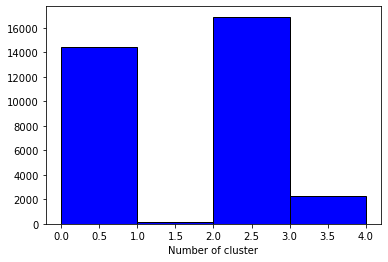

In [116]:
df_cluster_kmeans['cluster'].hist(bins=range(0,5,1),grid=False, color="blue", ec="black")
plt.xlabel("Number of cluster")
plt.show("Amount of R's")

In [117]:
#separar cada cluster para hacer su resumen
dfc0 = df_cluster_kmeans[df_cluster_kmeans['cluster']==0]
dfc1 = df_cluster_kmeans[df_cluster_kmeans['cluster']==1]
dfc2 = df_cluster_kmeans[df_cluster_kmeans['cluster']==2]
dfc3 = df_cluster_kmeans[df_cluster_kmeans['cluster']==3]

In [118]:
dfc0.describe()

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
count,14436.000000,14436.000000,14436.000000,14436.000000,12102.000000,12102.000000,1.443600e+04,14436.000000,14436.000000,14436.000000,...,14436.000000,14436.000000,14436.000000,14436.000000,14436.000000,14436.000000,1.443600e+04,14436.000000,14436.000000,14436.0
mean,222.739748,97.793710,19.580216,5.882516,280.887548,1446.425947,1.768507e+04,696.326421,1945.169018,15.195414,...,139.528263,4.859172,0.551884,2.123441,46.859753,2.076129,1.023213e+06,1.873441,24.502286,0.0
std,128.198041,230.229366,33.212938,11.176924,776.263240,3279.488015,4.211177e+04,4675.128209,9601.925940,34.807143,...,95.163856,5.488147,0.497318,1.220981,24.149277,0.845180,1.424021e+07,0.813115,37.022588,0.0
min,60.000000,2.000000,0.000000,0.000000,0.000000,-4200.000000,7.000000e+01,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,0.892857,1.000000,8.600000e+01,1.000000,0.000000,0.0
25%,117.000000,17.000000,4.000000,1.000000,0.000000,0.000000,3.062500e+03,0.000000,0.000000,1.000000,...,68.000000,1.000000,0.000000,1.000000,28.020375,1.000000,1.257900e+04,1.000000,2.000000,0.0
50%,192.000000,44.000000,10.000000,3.000000,0.000000,0.000000,8.290500e+03,14.450000,139.025000,4.000000,...,115.000000,3.000000,1.000000,2.000000,43.277675,2.000000,9.730200e+04,2.000000,8.000000,0.0
75%,306.000000,102.000000,23.000000,7.000000,0.000000,1504.650000,1.874675e+04,269.925000,1088.100000,13.000000,...,192.000000,6.000000,1.000000,3.000000,63.554240,3.000000,5.630860e+05,3.000000,30.000000,0.0
max,809.000000,8051.000000,702.000000,470.000000,12382.500000,46748.500000,1.473337e+06,201729.250000,516215.950000,598.000000,...,687.000000,71.000000,1.000000,5.000000,100.000000,5.000000,1.577936e+09,3.000000,262.000000,0.0


In [119]:
dfc1.describe()

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,140.000000,...,140.000000,140.000000,140.000000,140.0,140.000000,140.0,1.400000e+02,140.000000,140.000000,140.0
mean,500.921429,25012.900000,2591.357143,250.942857,1536.013673,4713.825390,5.445176e+06,4.229733e+05,9.658835e+05,0.621429,...,395.378571,0.878571,0.064286,5.0,99.120962,5.0,3.092317e+10,2.985714,0.200000,1.0
std,116.213712,9483.672744,882.033540,344.182731,1637.894311,4884.884827,1.999217e+06,4.427140e+05,9.681405e+05,1.727758,...,174.013870,1.924727,0.246142,0.0,1.722271,0.0,1.800356e+10,0.119092,1.212643,0.0
min,292.000000,11530.000000,1252.000000,2.000000,0.000000,-332.155477,2.665634e+06,0.000000e+00,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,5.0,90.702087,5.0,5.174233e+09,2.000000,0.000000,1.0
25%,408.750000,19048.750000,2042.000000,41.000000,0.000000,0.000000,4.193789e+06,5.154505e+04,1.749653e+05,0.000000,...,313.000000,0.000000,0.000000,5.0,99.182004,5.0,1.902394e+10,3.000000,0.000000,1.0
50%,519.000000,23039.500000,2416.000000,124.000000,1041.192105,2955.104561,5.036557e+06,3.558187e+05,6.659131e+05,0.000000,...,403.000000,0.000000,0.000000,5.0,99.680482,5.0,2.874983e+10,3.000000,0.000000,1.0
75%,548.250000,28784.000000,2935.250000,300.500000,2518.778131,9580.067646,6.352048e+06,6.688739e+05,1.444153e+06,0.000000,...,514.250000,1.000000,0.000000,5.0,100.000000,5.0,3.815277e+10,3.000000,0.000000,1.0
max,802.000000,78495.000000,6697.000000,2205.000000,4693.404669,15507.503061,1.856150e+07,3.339876e+06,5.226949e+06,15.000000,...,724.000000,12.000000,1.000000,5.0,100.000000,5.0,1.106348e+11,3.000000,10.000000,1.0


In [120]:
dfc2.describe()

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
count,16903.000000,16903.000000,16903.000000,16903.000000,16782.000000,16782.000000,1.690300e+04,16903.000000,16903.000000,16903.000000,...,16903.000000,16903.000000,16903.000000,16903.000000,16903.000000,16903.000000,1.690300e+04,16903.000000,16903.000000,16903.0
mean,383.790866,1075.287819,152.653138,26.797077,622.323738,2483.883901,2.018137e+05,8314.391073,22674.610563,5.046205,...,285.922499,7.828669,0.101225,3.757262,77.840827,4.074070,1.128874e+08,2.861563,1.191504,2.0
std,168.402952,1084.974727,141.322504,39.273001,1491.638123,3842.742038,2.028564e+05,16339.982513,39491.441097,17.206213,...,153.458899,8.573141,0.301635,1.014594,15.825561,0.883635,2.541735e+08,0.373515,3.580184,0.0
min,60.000000,4.000000,0.000000,0.000000,0.000000,-2900.000000,3.400000e+02,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,1.000000,15.714286,1.000000,2.320000e+02,1.000000,0.000000,2.0
25%,259.000000,310.000000,51.000000,6.000000,0.000000,0.000000,5.696700e+04,33.515000,638.350000,0.000000,...,167.000000,2.000000,0.000000,3.000000,66.467066,4.000000,4.405214e+06,3.000000,0.000000,2.0
50%,376.000000,675.000000,105.000000,14.000000,0.000000,222.580645,1.255080e+05,1567.300000,6398.540000,1.000000,...,279.000000,5.000000,0.000000,4.000000,80.251572,4.000000,2.051968e+07,3.000000,0.000000,2.0
75%,509.000000,1455.500000,207.000000,32.000000,705.786019,3996.490941,2.760853e+05,8037.910000,25887.910000,3.000000,...,385.000000,11.000000,0.000000,5.000000,91.360831,5.000000,9.188263e+07,3.000000,1.000000,2.0
max,809.000000,9088.000000,1487.000000,654.000000,20670.000000,58993.333333,1.446776e+06,138397.540000,405464.050000,421.000000,...,767.000000,123.000000,1.000000,5.000000,100.000000,5.000000,3.318177e+09,3.000000,91.000000,2.0


In [121]:
dfc3.describe()

,alive_time,completed_orders,cancelled_orders,b_cancelled_orders,avg_b_burn,r_burn,sum_order_price,sum_p_promo_subsidy,sum_r_promo_subsidy,first_online_first_order_gap,...,online_days,online_days_without_orders,is_churned_x,frequency_segment,frequency,monetary_segment,monetary,recency_segment,recency,cluster
count,2253.000000,2253.000000,2253.000000,2253.000000,2252.000000,2252.000000,2.253000e+03,2253.000000,2.253000e+03,2253.000000,...,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2253.000000,2.253000e+03,2253.000000,2253.000000,2253.0
mean,489.124723,7651.408788,925.717266,124.111407,1215.356364,4446.582435,1.537694e+06,102586.850448,2.486730e+05,2.004882,...,388.196183,2.263648,0.060808,4.932978,97.165081,4.980470,3.220822e+09,2.980470,0.216156,3.0
std,151.909580,3609.859188,463.456182,160.939848,1553.198216,4470.214979,7.198705e+05,103152.961626,2.492721e+05,7.481741,...,177.582182,3.571485,0.239031,0.255386,4.100055,0.150695,3.607507e+09,0.156478,1.788523,0.0
min,65.000000,677.000000,141.000000,0.000000,0.000000,-591.538462,8.361454e+04,0.000000,0.000000e+00,-1.000000,...,0.000000,0.000000,0.000000,3.000000,71.111111,3.000000,1.178200e+06,1.000000,0.000000,3.0
25%,381.000000,5064.000000,609.000000,26.000000,0.000000,0.000000,1.022560e+06,21725.000000,7.453769e+04,0.000000,...,286.000000,0.000000,0.000000,5.000000,96.433471,5.000000,9.403450e+08,3.000000,0.000000,3.0
50%,500.000000,6779.000000,822.000000,66.000000,767.218739,3583.865041,1.338221e+06,76398.850000,1.904595e+05,0.000000,...,398.000000,1.000000,0.000000,5.000000,98.961039,5.000000,1.972836e+09,3.000000,0.000000,3.0
75%,562.000000,9455.000000,1130.000000,164.000000,1976.959732,7249.480001,1.877254e+06,150103.290000,3.450382e+05,1.000000,...,513.000000,3.000000,0.000000,5.000000,99.706314,5.000000,4.124623e+09,3.000000,0.000000,3.0
max,809.000000,24475.000000,3781.000000,1553.000000,9895.919395,27266.063348,4.826008e+06,816831.470000,2.188462e+06,98.000000,...,765.000000,33.000000,1.000000,5.000000,100.000000,5.000000,2.574699e+10,3.000000,50.000000,3.0


# SA recency

In [122]:
## create a kmf object as km
kmf = KaplanMeierFitter() ## instantiate the class to create an object
df_2 = df_cluster_kmeans

#eje x: 2 días
T = df_2['alive_time']    ## days with 0 orders before last online
#si está churn o no
C = df_2['is_churned_x']     ## R churned or retained

#clasificados por frecuencia 
types2 = df_2['recency_segment']             ## Create the cohorts from the segment column
ix1 = (types2 == '1')   
ix2 = (types2 == '2')    
ix3 = (types2 == '3')    
ix4 = (types2 == '4')    
ix5 = (types2 == '5')    


kmf.fit(T[ix1], C[ix1], label='1 frequency')    ## fit the cohort 1 data
ax = kmf.plot(figsize=(14,8))


kmf.fit(T[ix2], C[ix2], label='2 frequency')       ## fit the cohort 2 data
ax1 = kmf.plot(figsize=(14,8), ax = ax)


kmf.fit(T[ix3], C[ix3], label='3 frequency')    ## fit the cohort 3 data
ax2 = kmf.plot(figsize=(14,8), ax = ax1)


kmf.fit(T[ix4], C[ix4], label='4 frequency')       ## fit the cohort 4 data
ax3 = kmf.plot(figsize=(14,8), ax = ax2)


kmf.fit(T[ix5], C[ix5], label='5 frequency')        ## fit the cohort 5 data
ax4= kmf.plot(figsize=(14,8), ax = ax3)      ## Plot the KM curve for three cohort on same x and y axis
ax4.set_xlabel("Alive Time")
ax4.set_ylabel("Churn probability %")
#xinterval = np.arange(0,200,10)            ## set intervals for X axis
#ax4.set_xticks(xinterval)

ValueError: Values must be numeric: no strings, datetimes, objects, etc.

# Life table

In [ ]:
#!pip install pyliferisk

In [ ]:
from pyliferisk import MortalityTable
from pyliferisk.mortalitytables import SPAININE2004, GKM95

In [ ]:
tariff = MortalityTable(nt=df_treeA.item())
#experience = MortalityTable(nt=GKM95, perc=85)

# Print the omega (limiting age) of the both tables:
print(tariff.w)
#print(experience.w)

print(tariff.qx[50] / 1000)
#print(experience.qx[50] / 1000)

In [ ]:
tariff = MortalityTable(nt=SPAININE2004)
experience = MortalityTable(nt=GKM95, perc=85)

# Print the omega (limiting age) of the both tables:
print(tariff.w)
print(experience.w)

# Print the qx at 50 years old:
print(tariff.qx[50] / 1000)
print(experience.qx[50] / 1000)

In [ ]:
SPAININE2004